# Numerical Optimization Algorithms

In this notebook, I will try to implement some numerical optimization algorithms and assess their performances. The examples follow Chapter 5 of Hamilton's time-series analysis textbook. The function to maximize will be $\ell(\phi)$, which in this particular case is the log-likelihood of an AR(1) process.

In [1]:
import torch
from torch import autograd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(14, 8))
plt.rc('grid', color='gray', alpha = 0.3, linestyle='solid')

In [2]:
# Define function to maximize (log-likelihood of an AR(1) process)

def log_likelihood_float(phi):
    y = torch.Tensor([0.8,0.2,-1.2,-0.4,0])
    T = 5
    s = torch.Tensor([0])
    for t in range(1,T-1):
        s += (y[t]-phi*y[t-1])**2
    return(-(T/2)*torch.log(torch.Tensor([2*math.pi]))+(1/2)*torch.log(1-phi**2) - (1/2)*(1-phi**2)*y[0]**2 - (1/2)*s)

def log_likelihood(phi):
    try:
        ll = torch.Tensor(list(map(log_likelihood_float, phi)))
    except:
        ll = log_likelihood_float(phi)
    return(ll)

In [3]:
# initial guess of phi
phi = torch.Tensor([0.0])

In [4]:
log_likelihood(phi)

tensor([-5.7347])

## Grid Search

Compute values of $\ell(\phi)$ for all $-1 < \phi < 1$ with increments of 0.1 and plot them:

In [5]:
a = -0.9
b = 0.9
grid = torch.arange(a, b,0.1)
ll_grid = log_likelihood(grid)

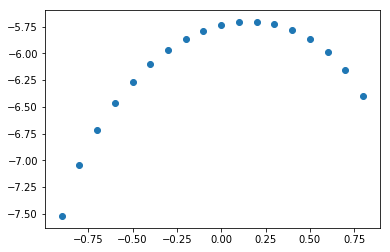

In [6]:
# Visualizing the data
plt.scatter(grid, ll_grid);

The next step is to find the 2 arg maximum values for phi and conducting another more granular grid search between the newly found values.

In [7]:
values, indices = ll_grid.topk(2)

In [8]:
values, indices

(tensor([-5.7047, -5.7071]), tensor([ 11,  10]))

In [9]:
# Define new grid
indices = indices.sort()[0]
a = grid[indices[0]]
b = grid[indices[1]]
grid = torch.arange(a, b,0.01)
ll_grid = log_likelihood(grid)

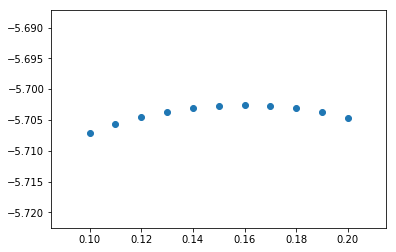

In [10]:
# Visualizing the data
plt.scatter(grid, ll_grid);

If we stop here, we can find the estimated argmax.

In [11]:
mle = grid[ll_grid.argmax()]

In [12]:
mle

tensor(0.1600)

We can expand the algorithm to go through an arbitrary number of iteratons.

In [13]:
def grid_search(function, a=-1, b=1, n_grid = 10, n_iterations = 5):
    
    for i in range(n_iterations):
        # Divide the search interval into n_grid segments
        step = (b-a)/n_grid
        grid = torch.arange(a, b, step)
        ll_grid = function(grid)

        # Define solution
        if i == n_iterations-1:
            mle = grid[ll_grid.argmax()]
            max_ll = ll_grid.max()
            return (mle, max_ll)
        # Define new search grif
        else:
            values, indices = ll_grid.topk(2)
            indices = indices.sort()[0]
            a = grid[indices[0]]
            b = grid[indices[1]]

In [14]:
grid_search(log_likelihood, n_grid=3, n_iterations=1000)

(tensor(0.1484), tensor(-5.7028))

Or, as it is more commonly done, we can expand the algorithm to iterate enough times untile the required accuracy is desired.

In [15]:
def grid_search(function, a=-1, b=1, n_grid = 10, accuracy = 0.01):
    
    i = 0
    step = (b-a)/n_grid
    
    while(step>accuracy):
        grid = torch.arange(a, b, step)
        ll_grid = function(grid)
        values, indices = ll_grid.topk(2)
        indices = indices.sort()[0]
        a = grid[indices[0]]
        b = grid[indices[1]]
        step = (b-a)/n_grid
            
    # Define solution
    mle = grid[ll_grid.argmax()]
    max_ll = ll_grid.max()
    return (mle, max_ll)

In [16]:
grid_search(log_likelihood, n_grid=3, accuracy = 0.0001)

(tensor(0.1485), tensor(-5.7028))

Grid search can be a very good method when we want to optimize w.r.t a single parameter. When the dimension of $\theta $ becomes large, it becomes quickly intractable. A method much more suited in this case is the steepest ascent algorithm.

# Steepest Ascent (Gradient descent)

This algorithm takes a differentiable functions and recursively updates its initial guess by moving in the direction of steepest ascent (indicated by the gradient). The speed of ascent is regulated by the learning rate hyperparameter.

In [17]:
# Analitically, we know that the argmax of the next function is (0,0)

def log_likelihood(theta):
    return(-1.5*theta[0]**2 - 2*theta[1]**2)

Once we have our function $\ell(\underline{\theta})$, we need to find its gradient, $g(\underline{\theta})$.

In [18]:
def gradient(theta):
    return(torch.tensor([-3*theta[0],- 4*theta[1]]))

In [19]:
# Define initial guess for theta and learning rate parameter

theta_0 = torch.Tensor([1,1])
lr = 0.01

Once we establish the initial guess for the parameter: $\underline{\theta}^0$, the steepest ascent is a recursive algorithm for which at every step t (t>0), we have:

$\underline{\theta}^{t} = \underline{\theta}^{t-1} + lr*g(\underline{\theta}^{t-1})$

Which componentwise means:

$\theta_{it} = \theta_{it-1} + lr*\frac{\partial\ell}{\partial\theta_{i}}(\theta_{it-1})$ 

And holds for each i. The algorithm can be iterated until some congergence criterion has been reached.

In [20]:
def steepest_ascent(function, gradient, guess = torch.Tensor([1,1]), lr=0.01, accuracy=0.0001):
    
    # Here, accuracy is expressed in terms of max component of the gradient
    step = torch.ones(1)
    while step.abs() > accuracy:
        guess += lr*gradient(guess)
        step = torch.max(gradient(guess))
        
    return (guess, function(guess))

In [21]:
mle, maximum = steepest_ascent(log_likelihood, gradient)

In [22]:
print(mle)

tensor(1.00000e-04 *
       [ 3.6362,  0.2458])


# Newton-Raphson

Provided that second derivatives of the $\ell$ function exist, and that $\ell$ is concave, then the NR algorithm converges more quickly (with less iterations) compared to the steepest ascent algorithm. The algorithm is based on maximizing the 2 order taylor expansion of $\ell$ aroung a guess which gets sequentially updated.
Contrary to the previous example, we will use the differentiations abilities of pytorch in order to compute the second derivatives (hessian matrix) so that we do not have to derive them analytically and hardcode them. The recursive algorithm can be summarized in one equation:

$\underline{\theta}^{t} = \underline{\theta}^{t-1} + lr*[-H(\underline{\theta}^{t-1})]^{-1}g(\underline{\theta}^{t-1})$

In [23]:
def log_likelihood(theta):
    res = -1.5*theta[0]**2 - 2*theta[1]**2
    return(torch.stack([res]))

def gradient(theta):
    return(torch.tensor([-3*theta[0],- 4*theta[1]]))

In [24]:
guess = torch.Tensor([1,1])
guess.requires_grad = True

In [25]:
# Compute gradient and Hessian using pytorch.autograd, code by apaszke
# We need the code to compute a Jacobian because the Hessian is computed as the gradient's Jacobian

def jacobian(fx, x, create_graph=False):                                                               
    jac = []
    # Reshapes the outputs of the function
    flat_fx = fx.reshape(-1)
    # Initializes grad_fx be the same size as the function output (if function outpus is a scalar, so grad_fx)
    grad_fx = torch.zeros_like(flat_fx) 
    # loops over the function outputs (only one is f is a scalar valued function)
    for i in range(len(flat_fx)):     
        # Since we only want to compute the gradient wrt the ith output, we will one-hot encode it and feed it to torch.autograd
        grad_fx[i] = 1. 
        # Computes the gradient of fx wrt x. grad_fx selects the component of f for which we want to compute the gradient
        grad_x, = torch.autograd.grad(flat_fx, x, grad_fx, retain_graph=True, create_graph=create_graph)
        # Appends the gradient wrt to the first output to the Jacobian (Jacobian = gradient for scalar valued functions)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_fx[i] = 0.
    # Returns a tensor by stacking all the gradients and gives the tensor the dimension of n_output x n_inputs
    return torch.stack(jac).reshape(fx.shape + x.shape)                                               
                                                                                                      
def hessian(y, x):       
    H = jacobian(jacobian(y, x, create_graph=True), x)
    return H

In [26]:
# Check that jacobian computes indeed the gradient (it should be [-3, -4])
jacobian(log_likelihood(guess), guess)

tensor([[-3., -4.]])

In [27]:
# Define the updating
def NR_step(function, theta_0, lr = 0.1, gradient_output = False):
    gradient = jacobian(log_likelihood(theta_0), theta_0)
    gradient = gradient.reshape(2,1)
    H = hessian(log_likelihood(theta_0), theta_0)
    H = H.reshape(2,2)
    inv_H = H.inverse()
    theta_1 = theta_0 + lr * torch.mm(-inv_H, gradient).reshape(-1)
    if gradient_output == False:
        return (theta_1)
    else:
        return (theta_1, gradient)

In [28]:
# Build a recursion (th code would greatly benefit from a decaying structure of the lr, we avoid this step for the notebook purposes)

grad_max = torch.ones(1)
lr = 0.01
max_steps = 1000
accuracy = 0.01 # measured on the gradient
guess_0 = torch.Tensor([1,1])
guess_0.requires_grad = True
step = 0

while grad_max.numpy() > accuracy and step <= 1000:
    guess_1, gradient = NR_step(log_likelihood, guess_0, lr = lr, gradient_output=True)
    grad_max = torch.max(gradient).abs()
    guess_0 = guess_1
    step += 1

In [29]:
# Check
print('Steps: ', step-1, 
      '\nLearning rate: ', lr,
     '\nArgmax: ', guess_0.detach().numpy(),
     '\nMax: ', log_likelihood(guess_0).detach().numpy())

Steps:  568 
Learning rate:  0.01 
Argmax:  [0.00328417 0.00328417] 
Max:  [-3.7750156e-05]


If $\underline{\theta}$ is n-dimensional, H will contain $\frac{n(n-1)}{2}$ values to be computed. This can be inefficient as n gets large. An alternative could be to guess H at each step based on the gradients and arguments differences. This is based off the fact that the Hessian is simply the Jacobian of the gradient. These methods are known as modified Newton-Raphson.